In [1]:
import re
import os
import fnmatch
from PIL import Image
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.contrib.concurrent import thread_map

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

def list_files_by_type(folder_path, file_type):
    filtered_files = []
    for file in os.listdir(folder_path):
        if fnmatch.fnmatch(file, f"*.{file_type}"):
            filtered_files.append(os.path.join(folder_path, file))
    return filtered_files

def process_image(args):
    file_path, label, transform = args  # Unpack the tuple
    image = Image.open(file_path).convert("RGB")
    default_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
    ])
    tensor = default_transform(image)
    if transform:
        tensor = transform(tensor)
    return tensor, torch.tensor(label, dtype=torch.long)

class CIFAKEDataset(Dataset):
    @staticmethod
    def extract_index_and_category(file_path):
        filename = os.path.basename(file_path)
        pattern = r"(\d+)(?: \((\d+)\))?\..+"
        match = re.match(pattern, filename)
        if match:
            index = int(match.group(1))
            category = int(match.group(2)) if match.group(2) else 0
            return index, category
        else:
            return None
    
    @staticmethod
    def load_folder(folder_path, label, category=None, transform=None, num_processes=1):
        print(f"Loading folder: {folder_path}")
        files = list_files_by_type(folder_path, "jpg")
        if category is not None:
            files = [file for file in files if CIFAKEDataset.extract_index_and_category(file)[1] == category]

        # Use process_map from tqdm.contrib.concurrent for better tqdm updates
        results = thread_map(process_image, [(file, label, transform) for file in files], max_workers=num_processes, chunksize=1)

        x = torch.stack([result[0] for result in results])
        y = torch.stack([result[1] for result in results])
        return x, y
        
    def __init__(self, folder_path, category=None, transform=None, num_processes=1):
        label_1_folders = [
            os.path.join(folder_path, "train/REAL"),
            os.path.join(folder_path, "test/REAL"),
        ]
        label_0_folders = [
            os.path.join(folder_path, "train/FAKE"),
            os.path.join(folder_path, "test/FAKE"),
        ]
        x1, y1 = CIFAKEDataset.load_folder(label_1_folders[0], 1, category, transform, num_processes)
        x2, y2 = CIFAKEDataset.load_folder(label_0_folders[0], 0, category, transform, num_processes)
        x3, y3 = CIFAKEDataset.load_folder(label_1_folders[1], 1, category, transform, num_processes)
        x4, y4 = CIFAKEDataset.load_folder(label_0_folders[1], 0, category, transform, num_processes)
        self.x = torch.cat((x1, x2, x3, x4))
        self.y = torch.cat((y1, y2, y3, y4))

    def __len__(self):
        return self.y.size(0)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def data_dim(self):
        return self.x[0].size()
    
    def show_example(self, idx):
        x, y = self[idx]
        image_array = x.permute(1, 2, 0).numpy()
        plt.imshow(image_array)
        plt.title(f"Label: {y}")
        plt.axis('off')
        plt.show()

Loading CIFAKEDataset...
Loading folder: data/CIFAKE\train/REAL


  0%|          | 0/50000 [00:00<?, ?it/s]

Loading folder: data/CIFAKE\train/FAKE


  0%|          | 0/50000 [00:00<?, ?it/s]

Loading folder: data/CIFAKE\test/REAL


  0%|          | 0/10000 [00:00<?, ?it/s]

Loading folder: data/CIFAKE\test/FAKE


  0%|          | 0/10000 [00:00<?, ?it/s]

Dataset loaded successfully!
Dataset length: 120000
Data dimension: torch.Size([3, 32, 32])
Showing example image...


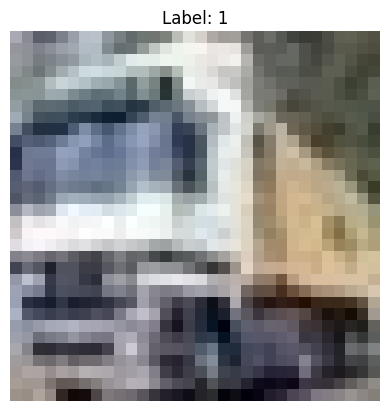

In [2]:
folder_path = "data/CIFAKE"
file_type = "jpg"
print("Loading CIFAKEDataset...")
data_set = CIFAKEDataset(folder_path, num_processes=4)
print("Dataset loaded successfully!")
print("Dataset length:", len(data_set))
print("Data dimension:", data_set.data_dim())
print("Showing example image...")
data_set.show_example(0)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the neural network model following the architecture in the provided diagram
class CIFAKEClassifier(nn.Module):
    def __init__(self):
        super(CIFAKEClassifier, self).__init__()
        # Assuming the input image size is 32x32x3 as per the rescale block in the diagram
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Convolutional layer with 32 outputs
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer with a 2x2 window and stride 2
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # Second convolutional layer with 32 outputs
        # Flatten layer will be applied in the forward pass
        self.fc1 = nn.Linear(32 * 8 * 8, 64)  # Dense layer with 64 units
        self.fc2 = nn.Linear(64, 1)  # Final dense layer with 1 unit for binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply ReLU activation function after first convolution
        x = self.pool(x)  # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply ReLU activation function after second convolution
        x = self.pool(x)  # Apply max pooling
        x = torch.flatten(x, 1)  # Flatten the tensor for the dense layer
        x = F.relu(self.fc1(x))  # Apply ReLU activation function after first dense layer
        x = torch.sigmoid(self.fc2(x))  # Apply sigmoid activation function for binary classification
        return x

# Instantiate the model
model = CIFAKEClassifier()

# Print the model structure
model.eval()

CIFAKEClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [4]:
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import numpy as np

# Hyperparameters
batch_size = 64
learning_rate = 1e-3
epochs = 5

# Create the training and testing splits
train_size = int(0.7 * len(data_set))
test_size = len(data_set) - train_size
train_dataset, test_dataset = random_split(data_set, [train_size, test_size])

# Dataloader for batch training
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train the model
def train_model(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            labels = labels.float()  # BCELoss expects labels to be in float format

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()  # Remove unnecessary dimensions
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.4f}')
                running_loss = 0.0

    print('Finished Training')

# Test the model
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images).squeeze()  # Remove unnecessary dimensions
            predicted = torch.round(outputs)  # Round to get binary predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

# Adding training and testing to the notebook
train_model(model, train_loader, criterion, optimizer, epochs)
test_model(model, test_loader)

Epoch 1, Batch 10, Loss: 0.6803
Epoch 1, Batch 20, Loss: 0.6414
Epoch 1, Batch 30, Loss: 0.6075
Epoch 1, Batch 40, Loss: 0.5603
Epoch 1, Batch 50, Loss: 0.4913
Epoch 1, Batch 60, Loss: 0.5248
Epoch 1, Batch 70, Loss: 0.4898
Epoch 1, Batch 80, Loss: 0.4748
Epoch 1, Batch 90, Loss: 0.4650
Epoch 1, Batch 100, Loss: 0.4587
Epoch 1, Batch 110, Loss: 0.4861
Epoch 1, Batch 120, Loss: 0.4396
Epoch 1, Batch 130, Loss: 0.4434
Epoch 1, Batch 140, Loss: 0.4073
Epoch 1, Batch 150, Loss: 0.4401
Epoch 1, Batch 160, Loss: 0.4366
Epoch 1, Batch 170, Loss: 0.4196
Epoch 1, Batch 180, Loss: 0.4255
Epoch 1, Batch 190, Loss: 0.3858
Epoch 1, Batch 200, Loss: 0.3951
Epoch 1, Batch 210, Loss: 0.3762
Epoch 1, Batch 220, Loss: 0.3950
Epoch 1, Batch 230, Loss: 0.3786
Epoch 1, Batch 240, Loss: 0.3975
Epoch 1, Batch 250, Loss: 0.4240
Epoch 1, Batch 260, Loss: 0.3731
Epoch 1, Batch 270, Loss: 0.3438
Epoch 1, Batch 280, Loss: 0.3893
Epoch 1, Batch 290, Loss: 0.3721
Epoch 1, Batch 300, Loss: 0.3672
Epoch 1, Batch 310,

In [5]:
torch.save(model.state_dict(), 'paper_model_cifake.pth')

In [6]:
from sklearn.metrics import precision_score, recall_score

# Test the model and calculate precision, recall, and specificity
def test_model_with_metrics(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images).squeeze()  # Remove unnecessary dimensions
            predicted = torch.round(outputs)  # Round to get binary predictions
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    precision = 100 * precision_score(all_labels, all_predictions)
    recall = 100 * recall_score(all_labels, all_predictions)

    # Calculate specificity
    TN = ((1 - np.array(all_predictions)) * (1 - np.array(all_labels))).sum()
    FN = ((1 - np.array(all_predictions)) * np.array(all_labels)).sum()
    specificity = 100 * TN / (TN + FN)

    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')
    print(f'Precision of the network on the test images: {precision:.2f}%')
    print(f'Recall of the network on the test images: {recall:.2f}%')
    print(f'Specificity of the network on the test images: {specificity:.2f}%')

# Call the modified test function
test_model_with_metrics(model, test_loader)


Accuracy of the network on the test images: 93.72%
Precision of the network on the test images: 91.74%
Recall of the network on the test images: 96.10%
Specificity of the network on the test images: 95.90%


In [7]:
def transform_image(image):
    """Transform the image to the required input size and format."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
    ])
    return transform(image)

def evaluate_folder(model, folder_path):
    """Evaluate a single folder of images and return the counts and rates."""
    count_0 = 0
    count_1 = 0
    total_images = 0

    for image_name in os.listdir(folder_path):
        try:
            image_path = os.path.join(folder_path, image_name)
            image = Image.open(image_path).convert("RGB")
            image = transform_image(image)
            image = image.unsqueeze(0)  # Add batch dimension
        except:
            print(f"Warning: failed to load one image {image_path}")
            continue

        with torch.no_grad():
            output = model(image).squeeze()  # Remove unnecessary dimensions
            predicted = torch.round(output)  # Round to get binary predictions
            label = predicted.item()

        if label == 0:
            count_0 += 1
        else:
            count_1 += 1

        total_images += 1

    rate_0 = (count_0 / total_images) * 100 if total_images > 0 else 0
    rate_1 = (count_1 / total_images) * 100 if total_images > 0 else 0

    return count_0, count_1, rate_0, rate_1

In [8]:
evaluate_folder(model, "data/sd_2_1_frogs")

(173, 27, 86.5, 13.5)

In [9]:
evaluate_folder(model, "data/sd_2_1_cats")

(79, 121, 39.5, 60.5)

In [10]:
evaluate_folder(model, "data/sd_2_1_dogs")

(107, 93, 53.5, 46.5)

In [11]:
evaluate_folder(model, "data/sd_2_1_dogs_with_modifiers")

(48, 16, 75.0, 25.0)

In [12]:
evaluate_folder(model, "data/sd_2_1_airplanes")

(169, 31, 84.5, 15.5)

In [13]:
evaluate_folder(model, "data/web-airplanes")

(77, 112, 40.74074074074074, 59.25925925925925)

In [14]:
evaluate_folder(model, "data/Cat")

(309, 12190, 2.4721977758220657, 97.52780222417795)

In [15]:
evaluate_folder(model, "data/Dog")

C:\Users\licaili193\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


(275, 12224, 2.2001760140811264, 97.79982398591888)

In [16]:
evaluate_folder(model, "data/CIFAKE/test/REAL")

(371, 9629, 3.71, 96.28999999999999)

In [17]:
evaluate_folder(model, "data/CIFAKE/test/FAKE")

(9203, 797, 92.03, 7.969999999999999)

Loading CIFAKEDataset 2...
Loading folder: data/CIFAKE-2\train/REAL


  0%|          | 0/12499 [00:00<?, ?it/s]

Loading folder: data/CIFAKE-2\train/FAKE


  0%|          | 0/12500 [00:00<?, ?it/s]

Loading folder: data/CIFAKE-2\test/REAL


  0%|          | 0/12499 [00:00<?, ?it/s]

Loading folder: data/CIFAKE-2\test/FAKE


  0%|          | 0/12500 [00:00<?, ?it/s]

Dataset loaded successfully!
Dataset length: 49998
Data dimension: torch.Size([3, 32, 32])
Showing example image...


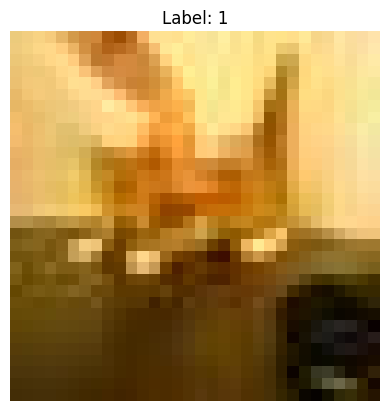

In [18]:
folder_path_2 = "data/CIFAKE-2"
print("Loading CIFAKEDataset 2...")
data_set_2 = CIFAKEDataset(folder_path_2, num_processes=4)
print("Dataset loaded successfully!")
print("Dataset length:", len(data_set_2))
print("Data dimension:", data_set_2.data_dim())
print("Showing example image...")
data_set_2.show_example(0)

In [27]:
# Instantiate the model
model_2 = CIFAKEClassifier()

# Print the model structure
model_2.eval()

CIFAKEClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [28]:
batch_size = 64
learning_rate = 1e-3
epochs = 5

train_size_2 = int(0.7 * len(data_set_2))
test_size_2 = len(data_set_2) - train_size_2
train_dataset_2, test_dataset_2 = random_split(data_set_2, [train_size_2, test_size_2])

# Dataloader for batch training
train_loader_2 = DataLoader(dataset=train_dataset_2, batch_size=batch_size, shuffle=True)
test_loader_2 = DataLoader(dataset=test_dataset_2, batch_size=batch_size, shuffle=False)

criterion_2 = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer_2 = Adam(model_2.parameters(), lr=learning_rate)

# Adding training and testing to the notebook
train_model(model_2, train_loader_2, criterion_2, optimizer_2, epochs)
test_model(model_2, test_loader_2)

Epoch 1, Batch 10, Loss: 0.6761
Epoch 1, Batch 20, Loss: 0.6546
Epoch 1, Batch 30, Loss: 0.5922
Epoch 1, Batch 40, Loss: 0.5229
Epoch 1, Batch 50, Loss: 0.4872
Epoch 1, Batch 60, Loss: 0.4279
Epoch 1, Batch 70, Loss: 0.3998
Epoch 1, Batch 80, Loss: 0.3053
Epoch 1, Batch 90, Loss: 0.3117
Epoch 1, Batch 100, Loss: 0.2949
Epoch 1, Batch 110, Loss: 0.3250
Epoch 1, Batch 120, Loss: 0.2941
Epoch 1, Batch 130, Loss: 0.2574
Epoch 1, Batch 140, Loss: 0.2771
Epoch 1, Batch 150, Loss: 0.2564
Epoch 1, Batch 160, Loss: 0.2963
Epoch 1, Batch 170, Loss: 0.2698
Epoch 1, Batch 180, Loss: 0.2563
Epoch 1, Batch 190, Loss: 0.2404
Epoch 1, Batch 200, Loss: 0.2785
Epoch 1, Batch 210, Loss: 0.2769
Epoch 1, Batch 220, Loss: 0.2440
Epoch 1, Batch 230, Loss: 0.2136
Epoch 1, Batch 240, Loss: 0.2456
Epoch 1, Batch 250, Loss: 0.2840
Epoch 1, Batch 260, Loss: 0.2837
Epoch 1, Batch 270, Loss: 0.2821
Epoch 1, Batch 280, Loss: 0.2279
Epoch 1, Batch 290, Loss: 0.2240
Epoch 1, Batch 300, Loss: 0.2111
Epoch 1, Batch 310,

In [29]:
# Call the modified test function
test_model_with_metrics(model_2, test_loader_2)

Accuracy of the network on the test images: 95.67%
Precision of the network on the test images: 95.06%
Recall of the network on the test images: 96.25%
Specificity of the network on the test images: 96.29%


In [32]:
evaluate_folder(model_2, "data/sd_2_1_frogs")

(175, 25, 87.5, 12.5)

In [33]:
evaluate_folder(model_2, "data/sd_2_1_cats")

(181, 19, 90.5, 9.5)

In [34]:
evaluate_folder(model_2, "data/sd_2_1_dogs")

(183, 17, 91.5, 8.5)

In [35]:
evaluate_folder(model_2, "data/sd_2_1_airplanes")

(110, 90, 55.00000000000001, 45.0)

In [37]:
evaluate_folder(model_2, "data/sd_2_1_dogs_with_modifiers")

(43, 21, 67.1875, 32.8125)